In [1]:
import pandas_datareader.data as web
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.stattools as st

In this worksheet, we're going to examine the Fisher hypothesis for the relationship between interest rate and inflation. The hypothesis states that interest rate $r_t$ fully reflects long-run movements in expected inflation $E(\pi_t)$. For the interest rate, we'll use the 3-month Treasury bill rate. We don't know what consumers *expect* for inflation, but we do have data from consumer opinion surveys conducted by the OECD that ask for opinions on future inflation. We will use that information as a proxy for expected inflation. 

We can compare the survey results with actual inflation and inspect how accurate consumers were in predicting inflation. The data is obtained from FRED below and are all in monthly frequency.

- **TB3MS** is the 3-month T-bill rate, denoted using $r_t$ below.
- **CSINFT02USM460S** is the survey of future inflation, denoted using $\pi_t$ below.
- **CPIAUCSL** is the CPI data.

In [2]:
# Import data from FRED
data = web.DataReader(['TB3MS', 'CSINFT02USM460S', 'CPIAUCSL'], 'fred', start='1981-01-01', end='2020-12-31')

1. Create a new column in the dataframe for realized (that is, future) inflation. You can name it however you want. I'm going to use $\pi^r_t$ as the symbol. Using CPI, the realized inflation is defined as: $\pi^r_t = 100 * \frac{\text{CPI}_{t+12} - \text{CPI}_{t}}{\text{CPI}_{t}}$. Since the data we have are in monthly intervals, we've defined realized inflation as the *annual change in CPI*. Pay attention to the time subscripts in the formula.

Note: You can use the **diff** and **shift** functions in Pandas but it's not required. If you've done this correctly, the realized inflation values from Feb 2020 to Dec 2020 should be *NaN*.

In [3]:
# Calculate realized inflation
data['Realized_Inflation'] = ((data['CPIAUCSL'].shift(-11) - data['CPIAUCSL']) / (data['CPIAUCSL'])) * 100

# Display the dataframe to check the new column
print(data.tail(15))

            TB3MS  CSINFT02USM460S  CPIAUCSL  Realized_Inflation
DATE                                                            
2019-10-01   1.65              3.0   257.155            1.087282
2019-11-01   1.54              3.1   257.879            0.919036
2019-12-01   1.54              2.8   258.630            0.875768
2020-01-01   1.52              2.9   258.906            1.196960
2020-02-01   1.52              2.8   259.246                 NaN
2020-03-01   0.29              2.5   258.150                 NaN
2020-04-01   0.14              2.4   256.126                 NaN
2020-05-01   0.13              3.3   255.848                 NaN
2020-06-01   0.16              3.3   257.004                 NaN
2020-07-01   0.13              3.6   258.408                 NaN
2020-08-01   0.10              3.4   259.366                 NaN
2020-09-01   0.11              3.3   259.951                 NaN
2020-10-01   0.10              3.0   260.249                 NaN
2020-11-01   0.09        

2. Estimate the following linear regression model using OLS: 
$$ r_t = \alpha + \beta \pi_t + u_t $$

Save the results and print out the summary.

In [4]:
y = data['TB3MS']
X = data[['CSINFT02USM460S']]
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TB3MS   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     403.1
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           1.79e-65
Time:                        19:58:09   Log-Likelihood:                -1120.4
No. Observations:                 480   AIC:                             2245.
Df Residuals:                     478   BIC:                             2253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.3924      0.431    -10.185      0.000      -5.240      -3.545
CSINFT02USM460S     2.1028      0.105     20.077      0.000       1.897       2.309
==============================================================================
Omnibus:                        9.396   Durbin-Watson:                   0.168
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.725
Skew:                          -0.343   Prob(JB):                      0.00773
Kurtosis:                       2.871   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: Below, you'll perform a range of diagnostic tests on the OLS residuals. All the modules you'll need for this have been imported above.

3. Plot the OLS residuals. Does it look like the residuals follow a white noise process?

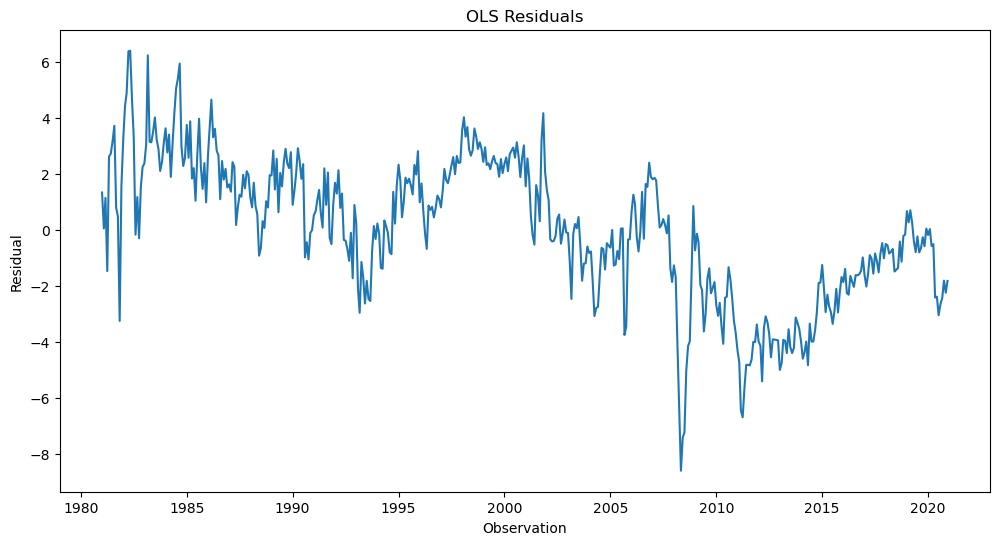

In [5]:
residuals = model.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('OLS Residuals')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

Based on the plot of the OLS residuals, it does indeed appear that the residuals are following a white noise process.

4. Test for autocorrelation in the residuals up to order 12 (i.e. 1 year). Interpret the results.

In [6]:
residuals.autocorr(lag=12)

0.7087835910746958

The autocorrelation coefficient of 0.709 is relatively high and positive. This suggests that there is a significant positive autocorrelation in the residuals up to the 12th lag (or 1 year). Positive autocorrelation implies that periods with higher-than-expected residuals tend to follow periods with higher-than-expected residuals, and the same goes for lower-than-expected residuals. The positive autocorrelation in the residuals up to the 12th lag indicates that the model might not be capturing some important dynamics in the data.

5. Test for ARCH up to order 6. Interpret the results.

In [7]:
squared_residuals = residuals**2
arch_test = dg.het_arch(squared_residuals, maxlag=6)
arch_test
p_values_arch = arch_test[1]
p_values_arch

C:\Users\bhale\AppData\Local\Temp\ipykernel_12472\4220693008.py:2: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = dg.het_arch(squared_residuals, maxlag=6)


2.3796022339956124e-49

The p-value obtained is approximately 2.3796022339956124e-49, which is extremely close to zero. A very low p-value suggests strong evidence against the null hypothesis. In this context, the null hypothesis for the ARCH test is that there is no ARCH effect. (i.e., the residuals are homoskedastic).

6. Test for normality in the residuals. Interpret the results.

In [8]:
jb_test = stats.jarque_bera(residuals)
jb_test

SignificanceResult(statistic=9.724724890258493, pvalue=0.0077321954094918596)

The test statistic obtained is approximately 9.7247248. The p-value obtained is approximately 0.00773219540. The p-value of 0.0077 is less than the commonly used significance level of 0.05. This suggests that you should reject the null hypothesis that the residuals are normally distributed. In this context, the null hypothesis for the Jarque-Bera test is that the residuals are normally distributed.

7. If the Fisher hypothesis holds, $\beta = 1$. Test this restriction and interpret the result.

In [9]:
model.t_test('CSINFT02USM460S = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1028      0.105     10.529      0.000       1.897       2.309

The t-test strongly rejects the Fisher hypothesis β=1 with a p-value of 0.000. This indicates that the interest rate does not fully reflect long-run movements in expected inflation as the Fisher hypothesis suggests.

8. You've learned how the residuals behave from your tests in steps 4, 5, 6. What effect does this have on your conclusion for step 7? Enter your answer below.

The rejection of the Fisher hypothesis (β=1) based on the t-test suggests that the interest rate does not fully reflect long-run movements in expected inflation.

However, considering the issues with the residuals (autocorrelation, ARCH effects, non-normality), the estimated coefficient for expected inflation (β) might be biased and inefficient.

The rejection of β=1 might be influenced by these residual issues, making it harder to draw definitive conclusions about the true relationship between interest rates and inflation.

There are some claims that the Fisher hypothesis might hold in some periods but not others. We'll inspect that by performing subsample tests. Estimate the same model, that is $r_t = \alpha + \beta \pi_t + u_t$, but over 4 subsample periods (just print out the summary):
- Jan 1981 to Dec 1990
- Jan 1991 to Dec 2000
- Jan 2001 to Dec 2010
- Jan 2011 to Dec 2020

In [10]:
# Jan 1981 to Dec 1990
# Filter data for the subsample period
subsample_1 = data['1981-01-01':'1990-12-31']

# Define dependent and independent variables
y_sub_1 = subsample_1['TB3MS']
X_sub_1 = subsample_1[['CSINFT02USM460S']]

# Add constant to the independent variables
X_sub_1 = sm.add_constant(X_sub_1)

# Fit the OLS model
model_sub_1 = sm.OLS(y_sub_1, X_sub_1).fit()

# Print the summary
print("Summary for Jan 1981 to Dec 1990:")
print(model_sub_1.summary())

Summary for Jan 1981 to Dec 1990:
                            OLS Regression Results                            
Dep. Variable:                  TB3MS   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     227.5
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           2.68e-29
Time:                        19:58:09   Log-Likelihood:                -218.31
No. Observations:                 120   AIC:                             440.6
Df Residuals:                     118   BIC:                             446.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const   

In [11]:
# Jan 1991 to Dec 2000
# Filter data for the subsample period
subsample_2 = data['1991-01-01':'2000-12-31']

# Define dependent and independent variables
y_sub_2 = subsample_2['TB3MS']
X_sub_2 = subsample_2[['CSINFT02USM460S']]

# Add constant to the independent variables
X_sub_2 = sm.add_constant(X_sub_2)

# Fit the OLS model
model_sub_2 = sm.OLS(y_sub_2, X_sub_2).fit()

# Print the summary
print("Summary for Jan 1991 to Dec 2000:")
print(model_sub_2.summary())

Summary for Jan 1991 to Dec 2000:
                            OLS Regression Results                            
Dep. Variable:                  TB3MS   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1724
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.679
Time:                        19:58:09   Log-Likelihood:                -161.48
No. Observations:                 120   AIC:                             327.0
Df Residuals:                     118   BIC:                             332.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const   

In [12]:
# Jan 2001 to Dec 2010
# Filter data for the subsample period
subsample_3 = data['2001-01-01':'2010-12-31']

# Define dependent and independent variables
y_sub_3 = subsample_3['TB3MS']
X_sub_3 = subsample_3[['CSINFT02USM460S']]

# Add constant to the independent variables
X_sub_3 = sm.add_constant(X_sub_3)

# Fit the OLS model
model_sub_3 = sm.OLS(y_sub_3, X_sub_3).fit()

# Print the summary
print("Summary for Jan 2001 to Dec 2010:")
print(model_sub_3.summary())

Summary for Jan 2001 to Dec 2010:
                            OLS Regression Results                            
Dep. Variable:                  TB3MS   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     13.43
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           0.000372
Time:                        19:58:09   Log-Likelihood:                -224.74
No. Observations:                 120   AIC:                             453.5
Df Residuals:                     118   BIC:                             459.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const   

In [13]:
# Jan 2011 to Dec 2020
# Filter data for the subsample period
subsample_4 = data['2011-01-01':'2020-12-31']

# Define dependent and independent variables
y_sub_4 = subsample_4['TB3MS']
X_sub_4 = subsample_4[['CSINFT02USM460S']]

# Add constant to the independent variables
X_sub_4 = sm.add_constant(X_sub_4)

# Fit the OLS model
model_sub_4 = sm.OLS(y_sub_4, X_sub_4, missing='drop').fit()

# Print the summary
print("Summary for Jan 2001 to Dec 2020:")
print(model_sub_4.summary())

Summary for Jan 2001 to Dec 2020:
                            OLS Regression Results                            
Dep. Variable:                  TB3MS   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     21.30
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           1.01e-05
Time:                        19:58:09   Log-Likelihood:                -131.43
No. Observations:                 120   AIC:                             266.9
Df Residuals:                     118   BIC:                             272.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const   

Based on what you observe in the 4 results above, make a comment.

The results clearly show that the relationship between interest rates and expected inflation varies over time. While the Fisher hypothesis holds during some periods, it's strongly rejected in others.

Different economic conditions, such as inflation rates, monetary policy regimes, and global economic events, can influence the relationship between interest rates and inflation expectations. For instance, periods of high inflation or significant monetary policy shifts might affect this relationship.

In summary, the Fisher hypothesis doesn't hold uniformly across all periods. While it holds strongly in some periods, it's rejected in others, indicating the importance of considering the specific economic context and conditions when examining the relationship between interest rates and inflation expectations.

Finally, let's see how well consumers did in forecasting inflation. Create a plot with time on the x-axis and two series: $\pi_t$ and $\pi^r_t$. What can you conclude from the plot? 

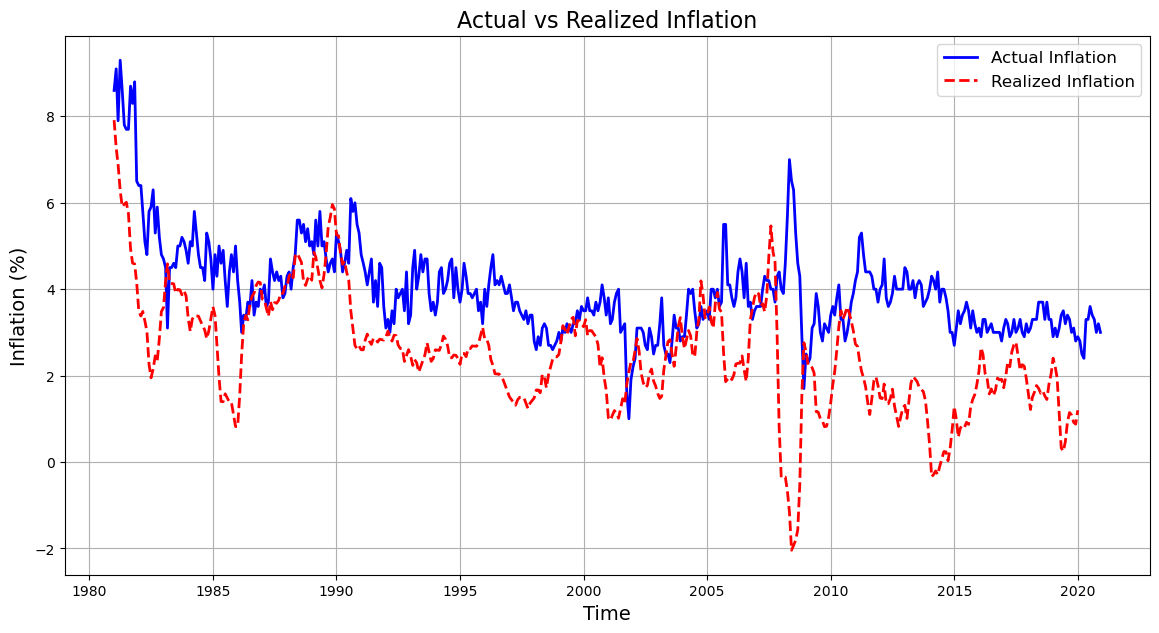

In [14]:
# Plotting Actual Inflation (pi_t) and Realized Inflation (pi_rt)
plt.figure(figsize=(14, 7))

# Actual Inflation (pi_t) from the survey data
plt.plot(data.index, data['CSINFT02USM460S'], label='Actual Inflation', color='blue', linewidth=2)

# Realized Inflation (pi_rt)
plt.plot(data.index, data['Realized_Inflation'], label='Realized Inflation', color='red', linestyle='--', linewidth=2)

# Set plot title and labels
plt.title('Actual vs Realized Inflation', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Inflation (%)', fontsize=14)
plt.legend(fontsize=12)

# Show grid
plt.grid(True)

# Show plot
plt.show()

As the blue line closely tracks the red dashed line across most of the time series, it suggests that consumers' expectations of inflation were generally accurate. This analysis can provide insights into consumer behavior, perceptions, and the factors influencing their expectations of inflation over time.